In [1]:
# Importing dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
from google.colab import drive
import pandas as pd
import os
import gdown


drive.mount('/content/drive')
folder_path = "/content/drive/My Drive/GDG_ML_WING_DATASET"
os.makedirs(folder_path, exist_ok=True)
print("Folder ready at:", folder_path)
url = "https://drive.google.com/file/d/1gyjh1b1bI2heFFOrMHLDXjJ7Zah9UYID/view?usp=drive_link"
file_id = url.split("/d/")[1].split("/")[0]
download_url = f"https://drive.google.com/uc?export=download&id={file_id}"
output = os.path.join(folder_path, "data.csv")
if not os.path.exists(output):
    print("Downloading file...")
    gdown.download(download_url, output, quiet=False)
else:
    print("File already exists at:", output)
DATA  = pd.read_csv(output)
print(DATA.head())


Mounted at /content/drive
Folder ready at: /content/drive/My Drive/GDG_ML_WING_DATASET
File already exists at: /content/drive/My Drive/GDG_ML_WING_DATASET/data.csv
   index       role committype                       fileextensions  \
0      0   frontend    feature                   [np.str_('js_ts')]   
1      1   frontend    feature                     [np.str_('css')]   
2      2  fullstack    feature                    [np.str_('html')]   
3      3   frontend   refactor                   [np.str_('js_ts')]   
4      4  fullstack    feature  [np.str_('js_ts'), np.str_('html')]   

   numfileschanged  linesadded  linesdeleted  numcommentsadded  \
0                4         312           100                 2   
1                4         191            74                 2   
2                4         275           146                 4   
3                4         245           164                 2   
4                2         692           378                 5   

     timeofc

In [4]:
# Basic exploration
print("Shape of dataset:", DATA.shape)
print("\nColumn names:", DATA.columns.tolist())


Shape of dataset: (1500, 10)

Column names: ['index', 'role', 'committype', 'fileextensions', 'numfileschanged', 'linesadded', 'linesdeleted', 'numcommentsadded', 'timeofcommit', 'commitmessage']


In [5]:
# Data info
print("\nDataset Info:")
print(DATA.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   index             1500 non-null   int64 
 1   role              1500 non-null   object
 2   committype        1500 non-null   object
 3   fileextensions    1500 non-null   object
 4   numfileschanged   1500 non-null   int64 
 5   linesadded        1500 non-null   int64 
 6   linesdeleted      1500 non-null   int64 
 7   numcommentsadded  1500 non-null   int64 
 8   timeofcommit      1500 non-null   object
 9   commitmessage     1500 non-null   object
dtypes: int64(5), object(5)
memory usage: 117.3+ KB
None


In [6]:
# Quick statistics
print("\nSummary Statistics:")
print(DATA.describe(include='all'))


Summary Statistics:
              index     role committype   fileextensions  numfileschanged  \
count   1500.000000     1500       1500             1500      1500.000000   
unique          NaN        4          4              278              NaN   
top             NaN  backend    feature  [np.str_('py')]              NaN   
freq            NaN      484        596              202              NaN   
mean     749.500000      NaN        NaN              NaN         3.810667   
std      433.157015      NaN        NaN              NaN         2.544891   
min        0.000000      NaN        NaN              NaN         1.000000   
25%      374.750000      NaN        NaN              NaN         2.000000   
50%      749.500000      NaN        NaN              NaN         3.000000   
75%     1124.250000      NaN        NaN              NaN         5.000000   
max     1499.000000      NaN        NaN              NaN        18.000000   

         linesadded  linesdeleted  numcommentsadded   

In [7]:
# Check missing values
print("\nMissing values per column:")
print(DATA.isnull().sum())


Missing values per column:
index               0
role                0
committype          0
fileextensions      0
numfileschanged     0
linesadded          0
linesdeleted        0
numcommentsadded    0
timeofcommit        0
commitmessage       0
dtype: int64


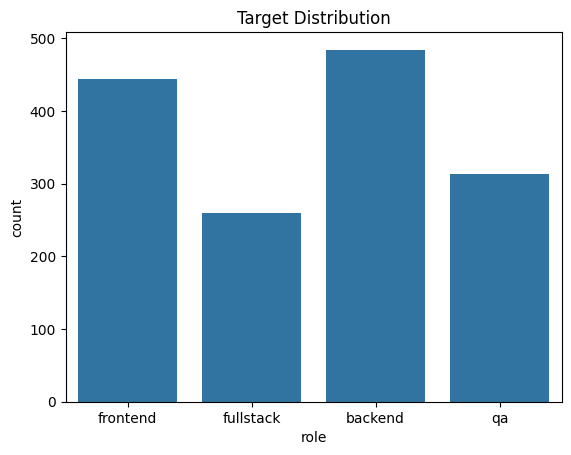

In [8]:
# Check target distribution
if "role" in DATA.columns:
    sns.countplot(data=DATA, x="role")
    plt.title("Target Distribution")
    plt.show()
else:
    print("Target column not yet identified, please confirm its name")

In [9]:
# Define target and features
X = DATA.drop(columns=["role"])   # Features
y = DATA["role"]                  # Target

In [10]:
# Detect numeric and categorical columns
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

Numeric features: ['index', 'numfileschanged', 'linesadded', 'linesdeleted', 'numcommentsadded']
Categorical features: ['committype', 'fileextensions', 'timeofcommit', 'commitmessage']


In [11]:
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)   # remove URLs
    text = re.sub(r"[^a-z\s]", "", text)         # remove non-alphabets
    text = re.sub(r"\s+", " ", text).strip()     # remove extra spaces
    text = " ".join([w for w in text.split() if w not in STOPWORDS])
    return text

DATA["clean_commit"] = DATA["commitmessage"].astype(str).apply(clean_text)

DATA[["commitmessage", "clean_commit"]].head(10)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,commitmessage,clean_commit
0,"""Implement responsive UI component with dropdo...",implement responsive ui component dropdown mod...
1,"""Refactor UI components: Implement responsive ...",refactor ui components implement responsive th...
2,"""feat: Implement responsive UI layout with mod...",feat implement responsive ui layout modal drop...
3,"""Refactored UI components for responsive layou...",refactored ui components responsive layout css...
4,"""feat: Implement responsive UI layout for logi...",feat implement responsive ui layout login page...
5,"""Refactor UI component: add responsive theme s...",refactor ui component add responsive theme sty...
6,"""Fixed authentication logic in backend API: va...",fixed authentication logic backend api validat...
7,"""Fixed authentication logic: validated API end...",fixed authentication logic validated api endpo...
8,"""feat: Implemented responsive UI component wit...",feat implemented responsive ui component modal...
9,"""Implement authentication logic for API endpoi...",implement authentication logic api endpoint ad...


In [12]:
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ["committype", "fileextensions", "timeofcommit"]

ohe = OneHotEncoder(handle_unknown="ignore")
cat_features = ohe.fit_transform(DATA[categorical_cols])

print("Categorical feature shape:", cat_features.shape)


Categorical feature shape: (1500, 442)


In [13]:
from sklearn.preprocessing import StandardScaler

num_cols = ["numfileschanged", "linesadded", "linesdeleted", "numcommentsadded"]

scaler = StandardScaler()
num_features = scaler.fit_transform(DATA[num_cols])

print("Numerical feature shape:", num_features.shape)


Numerical feature shape: (1500, 4)


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
text_features = tfidf.fit_transform(DATA["clean_commit"])

print("Text feature shape:", text_features.shape)


Text feature shape: (1500, 5000)


In [15]:
from scipy.sparse import hstack

X = hstack([text_features, cat_features, num_features])
y = DATA["role"]

print("Final feature matrix shape:", X.shape)


Final feature matrix shape: (1500, 5446)


In [16]:
file_dest = '/content/drive/My Drive/GDG_ML_WING_DATASET/preprocesss_dataset.csv' #SAVING THE MODIFIED VERSION
try:
    DATA.to_csv(file_dest, index=False)
    print("File saved successfully to:", file_dest)
except Exception as e:
    print("Error saving file:",e)

File saved successfully to: /content/drive/My Drive/GDG_ML_WING_DATASET/preprocesss_dataset.csv
